# Refrigeration System Analysis

This  analyis estimates the fuel savings that could be achieved by upgrading the refrigeration system on board F/V Eigil B. The calculation has three parts: first, parameters of the refrigeration systems are determined. Second, the fuel consumption rate of the generators is calculated as a function of load. Finally, the annual fuel consumption due to refrigeration is calculated based on the generator fuel consumption curves and the refrigeration load.

The analysis uses a simple model of new systems. The model includes a compressor (or two), two circulation pumps with vfd control, a condenser pump, a compressor cooling pump and a general term for system efficiency. A VFD on the compressor is not included, because it was found to have little value. The performance of the new compressors was looked up at a range of saturated suction temperatures and the data were used to estimate pump-down time.

The model of the old system uses the same components, but without any VFD control on the circulating pumps. Because I haven't been able to find performance data for the old compressor, its assumed to run at constant power rather than a power dependent on operating conditions.

The analysis is conducted in a Jupyter Notebook. A Jupyter Notebook allows text, figures and computer code to be presented in one document. Here, text is presented in black font fully left justified, while computer code (Python in this case) is presented a color-coded font and indented. Variables are defined and calculations are performed in the computer code "cells," while explanations are presented in the text "cells."

In [1]:
# This bit of code imports some software that the analysis uses 
# and defines some constants
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline
water_heat_cap = 8.35 # btu/gal-F
joule_per_btu = 1055 
sec_per_hr = 3600
watt_per_kW = 1000
kW_per_hp = 0.746

## Freezer load

### General cooling conditions
This section defines variables that are consistent for all of the proposed systems. "system_eff" (defined as 0.95 below) is the ratio of true system efficiency to manufacturer specified system efficiency. It's a factor to allow for losses that are not included in the manufacturer's estimates. It's difficult to know what the factor should be for this system, so 0.95 was chosen as a reasonable place holder and it can be adjusted to explore the sensitivity of results to system efficiency.

In [2]:
# Assumed system efficiency outside of the compressor
system_eff = 0.95

In [3]:
sea_temp = 59
target_temp = 33
aft_tank_capacity = 19448 # gallons
forward_tank_capacity = 14960 # gallons
n_aft_tank_pulldown = 33 # pulldowns per year
n_all_tank_pulldown = 1 # pulldowns per year
lbs_fish_cooled = 1.588e6
hrs_holding_aft_temp = 48.3
hrs_holding_all_temp = 0 # Herring season only--no data available
circ_pump_cap = 7.5 * 0.746 # kW
n_circ_pump = 2
condenser_pump_cap = 3 * 0.746 # kW
compressor_cool_pump = 2 * 0.746 # kW
hrs_filling_tanks = (64/60 * n_aft_tank_pulldown + 1.9 * \
                     n_all_tank_pulldown)*2
# rate at which the holds warm when at temperature (deg F/hr)
heat_infiltration_33 = 1.25 
# Assumed VFD efficiency based on Z1000 Specification
# Section 15172
vfd_eff = 0.98 

### New Bitzer system
The following data are from Bitzer Software v6.6.0 Open Drive Recips. Model W6FA-K with R717 (NH3). Condensing SDT 86 deg F. Liq subc 15 deg F, Suction gas superheat 15 deg F. Motor speed 1750/min, coupling 1:1. The parameter min_power is the power required to run the compressor at the minimum speed (900 r/min) at the minimum sst (24 deg F).

In [4]:
n_comp = 1
#deg F
bitzer_sst = np.array([42, 40, 38, 36, 34, 32, 30, 28, 26, 24]) 
bitzer_capacity = np.array([747, 714, 682, 651, 621, 591, 563, \
                535, 508, 482]) *1e3*n_comp*system_eff #btu/hr
bitzer_power = np.array([28.3, 28.4, 28.5, 28.5, 28.5, 28.4, \
    28.2, 28.0, 27.8, 27.5]) * n_comp #kW

The COP of the system is not used directly in this program, but it is a useful benchmark nonetheless. The COP is equal to capacity/power, as shown below.

In [5]:
strout = ''
factor = 1 /  system_eff * joule_per_btu / sec_per_hr \
    / watt_per_kW
for cop in bitzer_capacity / bitzer_power * factor:
    strout += '{:1.2f}'.format(cop) + ', '
print("The COP is \n", strout[:-2])
print("For Sat. Suction Temps of (deg F):\n", bitzer_sst)

The COP is 
 7.74, 7.37, 7.01, 6.69, 6.39, 6.10, 5.85, 5.60, 5.36, 5.14
For Sat. Suction Temps of (deg F):
 [42 40 38 36 34 32 30 28 26 24]


### New Frascold system

The following data are from Frascold Selection Software 3 v1.5. R507 model V20-59y, superheat = 15 F, useful fraction of superheat = 100%, condensing temp = 77, subcooling = 12 F.

In [6]:
n_frascold = 2 # number of compressors in quote
# deg F
frascold_sst = np.array([7,6,5,4,3,2,1,0,-1,-2,-5])*1.8+32
#btu/hr
frascold_capacity = np.array([98918,95580,92259,89016,85849,\
        82759,79745,76806,73942,71152,68436, 65793,63221])\
        /joule_per_btu*sec_per_hr * n_frascold * system_eff 
frascold_power = np.array([12.697, 12.763, 12.817, 12.859, \
        12.888, 12.905, 12.911, 12.905, 12.889, 12.862, \
        12.824, 12.77, 12.7]) * n_frascold #kW
strout = ''
counter =0
for cop in frascold_capacity / frascold_power * factor:
    counter += 1
    strout += '{:1.2f}'.format(cop) + ', '
    if counter % 9 == 0: strout += '\n'
print("The COP is: \n", strout[:-2])
strout = ''
counter =0
for cap in frascold_capacity:
    counter += 1
    strout += '{:0.0f}'.format(cap/1000) + ', '
    if counter % 9 == 0: strout += '\n'
print("The capacity (kbtu/hr) is: \n", strout[:-2])
strout = ''
counter = 0
for sst in frascold_sst:
    counter += 1
    strout += '{:2.1f}'.format(sst) + ', '
    if counter % 9 == 0: strout +='\n'
print("For Saturated Suction Temps of (deg F):\n", strout[:-2])

The COP is: 
 7.79, 7.49, 7.20, 6.92, 6.66, 6.41, 6.18, 5.95, 5.74, 
5.53, 5.34, 5.15, 4.98
The capacity (kbtu/hr) is: 
 641, 620, 598, 577, 557, 537, 517, 498, 479, 
461, 444, 427, 410
For Saturated Suction Temps of (deg F):
 44.6, 42.8, 41.0, 39.2, 37.4, 35.6, 33.8, 32.0, 30.2, 
28.4, 23.0


### Old Mycom system

Capacity and power data for the Mycom N4B compressor are not available, so the power is simply estimated based on the motor rating. This is one of the largest sources of uncertainty in the analysis.

In [7]:
motor_power = 40 * 0.746 # kW
aft_pump_down_time = 13.5 # hrs
total_time = 504.2 #hrs
motor_load_factor = 0.65 # assumed

In [8]:
mycom_sst = np.array([42, 34, 24])
mycom_ssp = np.array([76, 65, 53])
mycom_sdp = np.array([169, 169, 169])
# Power and capacity are for the N4WB, a newer model with a 
# higher capacity. The values for the N4WB derated so that
# the maximum power is 40 hp.
mycom_capacity = np.array([1502.7, 1242.5, 982]) * 1e3 # Btu/hr
mycom_power = np.array([82.4, 81.3, 78.8]) * kW_per_hp # kW
derating = motor_power/max(mycom_power)
mycom_capacity *= derating
mycom_power *= derating
counter =0
strout = ''
for cop in mycom_capacity / mycom_power * factor:
    counter += 1
    strout += '{:1.2f}'.format(cop) + ', '
    if counter % 9 == 0: strout += '\n'
print("The COP is: \n", strout)
strout = ''
counter =0
for cap in mycom_capacity:
    counter += 1
    strout += '{:0.0f}'.format(cap/1000) + ', '
    if counter % 9 == 0: strout += '\n'
print("The capacity (kbtu/hr) is: \n", strout[:-2])

The COP is: 
 7.54, 6.32, 5.15, 
The capacity (kbtu/hr) is: 
 729, 603, 477


### Circulation pump calculations
The circulation pumps account for over 1/3 of the power consumed. They are particularly impactful because not only do they require power to run, all of the power that they use ultimately ends up as heat that must be removed by the compressor--the more power the circulation pumps use, the more work must be done by the compressor.

This calculation considers how much water must be moved by the circulation pumps, and the associated power demand

In [9]:
pump_flow = aft_tank_capacity / (64/60) # gallons/hr
# maximum allowable change in water temperature in the 
# evaporator (deg F)
evap_temp_delta = 5 
f_min_flow = frascold_capacity / water_heat_cap \
    / evap_temp_delta # gal/hr
b_min_flow = bitzer_capacity / water_heat_cap \
    / evap_temp_delta # gal/hr
b_circ_vfd_ratio = b_min_flow / pump_flow # pump speed ratio
f_circ_vfd_ratio = f_min_flow / pump_flow
strout = "The minimum allowable pump speed ratios for the Frascold "
strout += "unit at \n the listed operating conditions are: "
print(strout)
strout = ''
counter = 0
for ratio in f_circ_vfd_ratio:
    counter += 1
    strout += '{:1.2F}'.format(ratio) + ', '
    if counter % 9 == 0: strout += '\n'
strout = strout[:-2]
print(strout)
strout = "The minimum allowable pump speed ratios for the Bitzer"
strout += " unit at \n the listed operating conditions are: "
print(strout)
strout = ''
counter = 0
for ratio in b_circ_vfd_ratio:
    counter += 1
    strout += '{:1.2F}'.format(ratio) + ', '
    if counter % 9 == 0: strout += '\n'
strout = strout[:-2]
print(strout)

def noncomp_loads(vfd, circ_vfd_ratio=1):
    """
    This function calculates the non-compressor loads associated
    with refrigeration.
    :param vfd: Is a vfd installed on the circ pumps? 
        (True/False)
    :param circ_vfd_ratio: optional input number to define pump 
        speed (ratio)
    :return noncomp_loads: Non-compressor refrigeration loads 
        (kW)
    """
    circ_load = circ_pump_cap * (circ_vfd_ratio)**3 * \
        n_circ_pump
    if vfd:
        circ_load /= vfd_eff
    noncomp_loads = circ_load + condenser_pump_cap + \
        compressor_cool_pump
    return noncomp_loads
other_loads_basic = noncomp_loads(False)

The minimum allowable pump speed ratios for the Frascold unit at 
 the listed operating conditions are: 
0.84, 0.81, 0.79, 0.76, 0.73, 0.70, 0.68, 0.65, 0.63, 
0.61, 0.58, 0.56, 0.54
The minimum allowable pump speed ratios for the Bitzer unit at 
 the listed operating conditions are: 
0.93, 0.89, 0.85, 0.81, 0.78, 0.74, 0.70, 0.67, 0.63, 
0.60


In [10]:
b_other_loads_vfd = noncomp_loads(True, circ_vfd_ratio = \
                                  b_circ_vfd_ratio)
f_other_loads_vfd = noncomp_loads(True, circ_vfd_ratio = \
                                  f_circ_vfd_ratio)

### Heat infiltration from ambient
The rate at which the compressor cools the hold is affected by the infiltration of heat from ambient. Based on interviews with the skipper, the hold temperature rises by about 1.25 deg F/hr once it is at temp. The rate of temperature change ($dT_{hold}$) with respect to time ($dt$) is defined by the equation below: 
$$\frac{d T_{hold}}{d t} = (T_{ambient}-T_{hold}) * UA $$ 

where $U$ is the average thermal conductivity of the hold and $A$ is the surface area of the hold. Since $UA$ and $T_{ambient}$ are constant for a given hold, the rate of heat loss is linearly related to the temperature of the hold. It's assumed that the rate of temperature change of both the aft and forward holds is the same. The heat infiltration rate associated with each SST for the two new compressors is calculated below simply by assuming that the rate of temperature change increases linearly from 0 when the water is at sea temperature to heat_infiltration_33 when the water is at 33 deg F.

In [11]:
# a different heat infiltration vector is defined for each 
# system because they have different amounts of operating 
# condition data which requires vectors of different
# lengths.
f_heat_infiltration = np.linspace(0, heat_infiltration_33,\
    len(frascold_capacity)) * water_heat_cap #btu/hr/gal
b_heat_infiltration = np.linspace(0, heat_infiltration_33, \
    len(bitzer_capacity)) * water_heat_cap #btu/hr/gal
m_heat_infiltration = np.linspace(0, heat_infiltration_33, \
    len(mycom_capacity)) * water_heat_cap #btu/hr/gal

def heat_load_fcn(hold_volume, heat_infiltration_rate, \
                  circ_vfd_ratio=1):
    """
    This function calculates the total heating load on the 
    system.
    :param circ_vfd_ratio: Defines pump speed as a ratio of pump 
        AC drive frequency to line frequency
    :param hold_volume: volume of the holds being cooled (gal)
    :param heat_infiltration_rate: Rate at which heat enters the
        hold from ambient (btu/hr/gal)
    :return : total heating load (btu/hr)
    """
    amb_load = hold_volume * heat_infiltration_rate # gal/hr
    circ_load = circ_pump_cap * (circ_vfd_ratio)**3 * \
        n_circ_pump
    return circ_load /joule_per_btu * watt_per_kW * sec_per_hr \
        + amb_load

## Auxiliary Generator BSFC
The fuel consumption as a function of load is calculated based on manufacturer's data: Engine Performance Curve John Deere  4045TFM75. John Deere. 2007.  <http://silniki.info.pl/upload/pdf/karta%20produktu%204045TFM75%20
55%20kW%20@1500%20&%201800.pdf>

The figure shows that a linear equation fits the data well. The fit shown in the figure below is used in the remainder of the report to estimate fuel consumption.

The BSFC shown below is for the engine only. It does 
not include the inefficiency of the motor side of the generator.
The estimated BSFC at a load of 36.9 kW is  240.1  gram/kWh
The estimated thermal efficiency of the generator at a load 
 of 32.8 kW is 30.0%


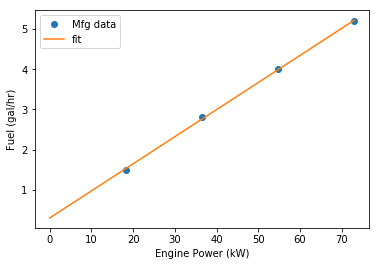

In [12]:
Aux1 = {}
Aux1['Capacity_kW'] = 65
Aux1['Fuel_gal_hr'] = np.array([1.5, 2.8, 4.0, 5.2])
# Note: According to the doc, the engine is rated to 73 kW, 
# although the generator on board is rated to 65 kW. The 73 kW 
# engine rating is used here. The generator load should be 
# divided by an efficiency of 65/73 to get the engine load.
ratedpower = 73 # kW
Aux1['gen_eff'] = 65/73
Aux1['Power_kW'] = ratedpower * np.array([0.25, 0.5, 0.75, 1.0])
Aux1['bsfc_coeffs'] = np.polyfit(Aux1['Power_kW'], \
                                 Aux1['Fuel_gal_hr'], 1)
powertest = np.linspace(0, ratedpower, 100)
fueltest = Aux1['bsfc_coeffs'][0]*powertest + \
    Aux1['bsfc_coeffs'][1]
plt.plot(Aux1['Power_kW'], Aux1['Fuel_gal_hr'], 'o', \
         label='Mfg data')
plt.plot(powertest, fueltest, label='fit')
plt.ylabel('Fuel (gal/hr)')
plt.xlabel('Engine Power (kW)')
plt.legend(loc='best')

# ---- Sanity check-----
# Used to pick a central value to check the efficiency
testpoint = int(len(powertest)/2) 
fuel_density = 3179 # assumed fuel density (gram/gallon)
# gram/kWh
bsfc = fueltest[testpoint]/powertest[testpoint] * fuel_density
eng_load = '{:2.1f}'.format(powertest[testpoint])
print("The BSFC shown below is for the engine only. It does" +\
     " \nnot include the inefficiency of the motor side of the " +\
     "generator.")
print("The estimated BSFC at a load of " + eng_load + \
      ' kW is ', '{:3.1f}'.format(bsfc), ' gram/kWh')
gen_eff = powertest[testpoint] * Aux1['gen_eff']\
    / (134000 * fueltest[testpoint] / 3412)
gen_eff = '{:2.1f}'.format(gen_eff*100)
gen_load = '{:2.1f}'.format(powertest[testpoint] * \
                            Aux1['gen_eff'])
print("The estimated thermal efficiency of the generator at " +\
    "a load \n of " + gen_load + " kW is " + gen_eff + "%")

The second auxiliary generator has the same engine (John Deere 4045TFM75), but the generator is rated to 100 kW rather than 65 kW. Data sheets for the 4045TFM75 reveals that the engine is rated to 80 kW under M1 conditions (operating over 3000 hours per year and load factors over 65%) and to 101 kW under M3 conditions (up to 2000 hours per year, and load factors under 50%). Since the both auxiliary generators use the same engine, the same fuel consumption curve is used for each.

In [13]:
Aux2 = copy.copy(Aux1)
Aux2['Capacity_kW'] = 100

## Fuel consumption calculation
There are three modes considered here:
1.) Filling the tanks with water
2.) Pulling the hold down to temperature
3.) Maintaining hold temperature

### Filling tanks

In [14]:
load_kw = n_circ_pump * circ_pump_cap / Aux1['gen_eff']
load_kw_vfd = load_kw / vfd_eff
fuel_a = Aux1['bsfc_coeffs'][0]
fuel_b = Aux1['bsfc_coeffs'][1]
filling_fuel = (fuel_a*load_kw + fuel_b) * hrs_filling_tanks
filling_fuel_vfd = (fuel_a*load_kw_vfd + fuel_b) * \
    hrs_filling_tanks
print("Fuel used to fill fish holds (gal): ", filling_fuel)
print("Fuel used to fill fish holds w/ vfd (gal): ", \
      filling_fuel_vfd)
print('Total season hours to fill and empty tanks: ', \
      hrs_filling_tanks)
print('Calculated engine load (kW): ', load_kw)
print('Fuel consumption rate with both circ pumps running \n' + \
    'at capacity (gal/hr): ', fuel_a*load_kw + fuel_b)

Fuel used to fill fish holds (gal):  85.1071716923
Fuel used to fill fish holds w/ vfd (gal):  86.389767033
Total season hours to fill and empty tanks:  74.2
Calculated engine load (kW):  12.567230769230768
Fuel consumption rate with both circ pumps running 
at capacity (gal/hr):  1.14699692308


### Pulling down hold
The following function will be used repeatedly to estimate fuel consumption per hold pull down. The function takes the hold capacity and compressor properties as inputs and calculates time to cool the hold and fuel required to cool the hold. The sea temperature, target temperature and engine properties defined above are also used by the function, but they are not passed to the function as input arguments; instead, they simply reference the values defined in earlier code cells.

In [15]:
def pulldown_calculator(water_vol, comp_sst, comp_power, \
                        comp_cap, other_loads, heat_load):
    """ A function for calculating consumption of a compressor 
        during pull down
    :param water_vol: volume of water to be cooled (gallons)
    :param comp_sst: array of saturated suction temperatures 
        associated with compressor data (F)
    :param comp_power: array of compressor power requirements 
        associated with the listed SSTs (kW)
    :param comp_cap: array of compressor capacities associated 
        with the listed SSTs (btu/hr)
    :param other_loads: non-compressor loads on the generator 
        (kW)
    :param heat_load: heat entering the hold can be an array 
        or a scalar (btu/hr)
    :return time: time to pull down hold (hrs)
    :return fuel: fuel burned during pull down (gallon)
    """
    
    btus_removed = water_vol * water_heat_cap * (sea_temp - \
                                                 target_temp)
    if len(comp_sst) > 1:
        delta_sst = comp_sst[0] - comp_sst[1]
        btu_per_sst = btus_removed/(delta_sst * len(comp_sst))
    else:
        btu_per_sst = btus_removed
        delta_sst = 1
    times = btu_per_sst * delta_sst / (comp_cap - heat_load)
    fuel_a = Aux1['bsfc_coeffs'][0]
    fuel_b = Aux1['bsfc_coeffs'][1]
    fuel = sum((fuel_a * (comp_power+other_loads) / \
                Aux1['gen_eff'] + fuel_b)*times)
    time = sum(times)
    return time, fuel

#### Salmon season: Aft holds only

This section calculates the fuel consumed during to pump down the two aft holds during the salmon season. It uses the function defined above to calculate fuel consumption per pump down cycle, then multiplies by the number of cycles.

In [16]:
# --------------------------- NO VFD--------------------------------
## ---------------Bitzer
heat_load = heat_load_fcn(aft_tank_capacity, \
    b_heat_infiltration, circ_vfd_ratio = 1)
b_time, b_fuel = pulldown_calculator(aft_tank_capacity,\
    bitzer_sst, bitzer_power, bitzer_capacity, \
    other_loads_basic, heat_load)
b_salmon_pumpdown_fuel = b_fuel * n_aft_tank_pulldown

## ----------Frascold
heat_load = heat_load_fcn(aft_tank_capacity, \
    f_heat_infiltration, circ_vfd_ratio = 1)
f_time, f_fuel = pulldown_calculator(aft_tank_capacity, \
    frascold_sst, frascold_power, frascold_capacity, \
    other_loads_basic, heat_load)
f_salmon_pumpdown_fuel = f_fuel * n_aft_tank_pulldown
heat_load = heat_load_fcn(aft_tank_capacity, \
    m_heat_infiltration, circ_vfd_ratio = 1)
m_time, m_fuel = pulldown_calculator(aft_tank_capacity, 
    mycom_sst, mycom_power, mycom_capacity, other_loads_basic, \
    heat_load)
m_salmon_pumpdown_fuel = m_fuel * n_aft_tank_pulldown

# --------------------------- Circ Pump VFD ------------------------
## -------------- Bitzer
heat_load = heat_load_fcn(aft_tank_capacity, \
    b_heat_infiltration, circ_vfd_ratio = b_circ_vfd_ratio)
bv_time, bv_fuel = pulldown_calculator(aft_tank_capacity, \
    bitzer_sst, bitzer_power, bitzer_capacity, \
    b_other_loads_vfd, heat_load)
bv_salmon_pumpdown_fuel = bv_fuel * n_aft_tank_pulldown

## --------------- Frascold
heat_load = heat_load_fcn(aft_tank_capacity, \
    f_heat_infiltration, circ_vfd_ratio = f_circ_vfd_ratio)
fv_time, fv_fuel = pulldown_calculator(aft_tank_capacity, \
    frascold_sst, frascold_power, frascold_capacity, \
    f_other_loads_vfd, heat_load)
fv_salmon_pumpdown_fuel = fv_fuel * n_aft_tank_pulldown

# --------------------------- Results ------------------------------
strout = '{:2.1f}'.format(bv_time)
print("Time to pull down both aft holds once with Bitzer" + \
      " and VFD (hrs):\n ", strout, '\n')
strout = '{:3.1f}'.format(bv_time * n_aft_tank_pulldown)
print("Time to pull down hold per salmon season with Bitzer" + \
      " and VFD \n (hrs): ", strout, '\n')
strout = '{:4.1f}'.format(bv_salmon_pumpdown_fuel)
print("Fuel used to pump down holds during salmon season" + \
      " with Bitzer \n and VFD (gal):", strout, '\n')
strout = '{:2.1f}'.format(b_salmon_pumpdown_fuel)
print("Fuel used to pump down holds during salmon season" + \
      " with Bitzer \n and no VFD (gal): ", strout, '\n')
strout = '{:2.1f}'.format(fv_time)
print("Time to pull down both aft holds once with Frascold" + \
      " and vfd (hrs):\n ", strout, '\n')
strout = '{:2.1f}'.format(fv_time*n_aft_tank_pulldown)
print("Time to pull down hold per salmon season with " + \
      "Frascold (hrs):\n ", strout, '\n')
strout = '{:4.0f}'.format(fv_salmon_pumpdown_fuel)
print("Fuel used to pump down holds during salmon season " + \
      "with Frascold \nand vfd (gal): ", strout, '\n')
strout = '{:0.0f}'.format(f_time)
print("Time to pump down aft holds once " + \
      "with Frascold and no vfd (hr):\n ", strout, '\n')
strout = '{:4.0f}'.format(f_salmon_pumpdown_fuel)
print("Fuel used to pump down holds during salmon season " + \
      "with Frascold \nand no vfd (gal):\n ", strout, '\n')
strout = '{:2.1f}'.format(m_time)
print("Time to pull down both aft holds once with Mycom (hrs)"+\
      ":\n ", strout, '\n')
strout = '{:3.0f}'.format(m_time*n_aft_tank_pulldown)
print("Time to pull down hold per salmon season with mycom" + \
      " (hrs):\n ", strout, '\n')
strout = '{:4.0f}'.format(m_salmon_pumpdown_fuel)
print("Fuel used to pump down holds during salmon season" + \
      " with Mycom (gal):\n ", strout, '\n')

Time to pull down both aft holds once with Bitzer and VFD (hrs):
  10.2 

Time to pull down hold per salmon season with Bitzer and VFD 
 (hrs):  335.4 

Fuel used to pump down holds during salmon season with Bitzer 
 and VFD (gal): 1027.2 

Fuel used to pump down holds during salmon season with Bitzer 
 and no VFD (gal):  1278.6 

Time to pull down both aft holds once with Frascold and vfd (hrs):
  13.8 

Time to pull down hold per salmon season with Frascold (hrs):
  456.3 

Fuel used to pump down holds during salmon season with Frascold 
and vfd (gal):  1267 

Time to pump down aft holds once with Frascold and no vfd (hr):
  15 

Fuel used to pump down holds during salmon season with Frascold 
and no vfd (gal):
  1693 

Time to pull down both aft holds once with Mycom (hrs):
  11.0 

Time to pull down hold per salmon season with mycom (hrs):
  365 

Fuel used to pump down holds during salmon season with Mycom (gal):
  1322 



#### Herring season: all holds

This section does the same calculation as above, but for the herring season instead of the salmon season. The herring season has a different volume of water to cool and only one pull down cycle instead of 33.

In [17]:
# --------------------------- NO VFD-------------------------------
other_loads = noncomp_loads(False)
tank_cap = aft_tank_capacity + forward_tank_capacity

heat_load = heat_load_fcn(tank_cap,  b_heat_infiltration, \
    circ_vfd_ratio=1)
b_time, b_fuel = pulldown_calculator(tank_cap, bitzer_sst, \
    bitzer_power, bitzer_capacity, other_loads_basic, heat_load)
b_herring_pumpdown_fuel = b_fuel * n_all_tank_pulldown

heat_load = heat_load_fcn(tank_cap, f_heat_infiltration, \
    circ_vfd_ratio=1)
f_time, f_fuel = pulldown_calculator(tank_cap, frascold_sst, \
    frascold_power, frascold_capacity, other_loads_basic, \
    heat_load)
f_herring_pumpdown_fuel = f_fuel * n_all_tank_pulldown

heat_load = heat_load_fcn(tank_cap, m_heat_infiltration, \
    circ_vfd_ratio=1)
m_time, m_fuel = pulldown_calculator(tank_cap, mycom_sst, \
    mycom_power, mycom_capacity, other_loads_basic, heat_load)
m_herring_pumpdown_fuel = m_fuel * n_all_tank_pulldown

# --------------------------- Circ Pump VFD------------------------
other_loads = noncomp_loads(True, circ_vfd_ratio = \
    b_circ_vfd_ratio)
heat_load= heat_load_fcn(tank_cap, b_heat_infiltration, \
    circ_vfd_ratio = b_circ_vfd_ratio)
bv_time, bv_fuel = pulldown_calculator(tank_cap, bitzer_sst, \
    bitzer_power, bitzer_capacity, b_other_loads_vfd, heat_load)
bv_herring_pumpdown_fuel = bv_fuel * n_all_tank_pulldown
heat_load= heat_load_fcn(tank_cap, f_heat_infiltration, \
    circ_vfd_ratio = f_circ_vfd_ratio)
fv_time, fv_fuel = pulldown_calculator(tank_cap, frascold_sst, \
    frascold_power, frascold_capacity, f_other_loads_vfd, \
    heat_load)
fv_herring_pumpdown_fuel = fv_fuel * n_all_tank_pulldown

# --------------------------- Results ------------------------------
strout = '{:2.1f}'.format(bv_time*n_all_tank_pulldown)
print("time to pull down hold per herring season with " + \
      "Bitzer and VFD (hrs): ", strout, '\n')
strout = '{:0.0f}'.format(bv_herring_pumpdown_fuel)
print("Fuel used to pump down holds during herring season" + \
      " with Bitzer and \nVFD (gal): ", strout, '\n')
strout = '{:0.0f}'.format(b_herring_pumpdown_fuel)
print("Fuel used to pump down holds during herring season" + 
      " with Bitzer and \nno VFD (gal): ", strout, '\n')
strout = '{:0.0f}'.format(f_time*n_all_tank_pulldown)
print("time to pull down hold per herring season with" +\
      " Frascold and no \nVFD (hrs): ", strout, '\n')
strout = '{:0.0f}'.format(fv_time*n_all_tank_pulldown)
print("time to pull down hold per herring season with" + \
      " Frascold and vfd \n(hrs): ", strout, '\n')
strout = '{:0.0f}'.format(f_herring_pumpdown_fuel)
print("Fuel used to pump down holds during herring season" + \
      " with Frascold \nand no vfd (gal): ", strout, '\n')
strout = '{:0.0f}'.format(fv_herring_pumpdown_fuel)
print("Fuel used to pump \ndown holds during herring season" + \
      " with Frascold and \nvfd (gal): ", strout, '\n')
strout = '{:0.0f}'.format(m_time*n_all_tank_pulldown)
print("time to pull down hold per herring season with" + \
      " mycom (hrs): ", strout, '\n')
strout = '{:0.0f}'.format(m_herring_pumpdown_fuel)
print("Fuel used to pump down holds during herring season" + \
      "with Mycom (gal):\n", strout, '\n')

time to pull down hold per herring season with Bitzer and VFD (hrs):  28.4 

Fuel used to pump down holds during herring season with Bitzer and 
VFD (gal):  86 

Fuel used to pump down holds during herring season with Bitzer and 
no VFD (gal):  123 

time to pull down hold per herring season with Frascold and no 
VFD (hrs):  94 

time to pull down hold per herring season with Frascold and vfd 
(hrs):  47 

Fuel used to pump down holds during herring season with Frascold 
and no vfd (gal):  314 

Fuel used to pump 
down holds during herring season with Frascold and 
vfd (gal):  129 

time to pull down hold per herring season with mycom (hrs):  41 

Fuel used to pump down holds during herring seasonwith Mycom (gal):
 150 



In [18]:
print(tank_cap, aft_tank_capacity, forward_tank_capacity)

34408 19448 14960


### Maintaining temp

There are two subsections here: cooling off fish, and maintaining the hold independently of the fish. The fuel used to cool fish is calculated by assuming that the compressor is operating at conditions when the hold is cold-an SST of 24 degrees. The time to pump out the btus in the fish is calculated at that condition (assuming that the fish have the same heat capacity as water on a mass basis). This time is then subtracted from the total freezer run time to get the time required to simply maintain temperature.

The temperature maintenance fuel demand is calculated by assuming that the compressor will run continuously at its minimum speed. The compressor power is then used to calculate the fuel consumption rate.

In [19]:
total_maintenance_hrs = 96
duty_cycle = 0.5 # this is the fraction of time that the 
# compressor is on. duty_cycle is assumed to be constant, 
# although in principle it will depend on system capacity.
b_fish_hours = total_maintenance_hrs * duty_cycle
bv_fish_hours = total_maintenance_hrs * duty_cycle
b_fish_cooling_fuel = b_fish_hours * (fuel_a * \
    (bitzer_power[-1] + other_loads_basic)/ Aux1['gen_eff'] +\
    fuel_b)
bv_fish_cooling_fuel = bv_fish_hours * (fuel_a * \
    (bitzer_power[-1] + b_other_loads_vfd[-1]) / \
    Aux1['gen_eff'] + fuel_b)

f_fish_hours = total_maintenance_hrs * duty_cycle
fv_fish_hours = total_maintenance_hrs * duty_cycle
f_fish_cooling_fuel = f_fish_hours * (fuel_a * \
    (frascold_power[-1] + other_loads_basic) / Aux1['gen_eff'] \
    + fuel_b)
fv_fish_cooling_fuel = fv_fish_hours * (fuel_a * \
    (frascold_power[-1] + f_other_loads_vfd[-1]) /\
    Aux1['gen_eff'] + fuel_b)

m_fish_hours = total_maintenance_hrs * duty_cycle
m_fish_cooling_fuel = m_fish_hours * (fuel_a * \
    (mycom_power[-1] + other_loads_basic) / Aux1['gen_eff'] + \
    fuel_b)
print("Fuel used to cool fish on board with Bitzer and" + \
      " vfd (gal): ", '{:0.0f}'.format(bv_fish_cooling_fuel))
print("Fuel used to cool fish on board with Bitzer and" + \
      " no vfd (gal): ", '{:0.0f}'.format(b_fish_cooling_fuel))
print("Fuel used to cool fish on board with Frascold and" + \
      " vfd (gal): ", '{:0.0f}'.format(fv_fish_cooling_fuel))
print("Fuel used to cool fish on board with Frascold (gal)" + \
      " and no vfd: ", '{:0.0f}'.format(f_fish_cooling_fuel))
print("Fuel used to cool fish on board with Mycom (gal)" + \
      ": ", '{:0.0f}'.format(m_fish_cooling_fuel))

Fuel used to cool fish on board with Bitzer and vfd (gal):  137
Fuel used to cool fish on board with Bitzer and no vfd (gal):  169
Fuel used to cool fish on board with Frascold and vfd (gal):  127
Fuel used to cool fish on board with Frascold (gal) and no vfd:  161
Fuel used to cool fish on board with Mycom (gal):  172


In [20]:
b_total_fuel = b_fish_cooling_fuel + b_herring_pumpdown_fuel + \
    b_salmon_pumpdown_fuel + filling_fuel
f_total_fuel = f_fish_cooling_fuel + f_herring_pumpdown_fuel + \
    f_salmon_pumpdown_fuel + filling_fuel
bv_total_fuel = bv_fish_cooling_fuel + bv_herring_pumpdown_fuel\
    + bv_salmon_pumpdown_fuel + filling_fuel_vfd
fv_total_fuel = fv_fish_cooling_fuel + fv_herring_pumpdown_fuel\
    + fv_salmon_pumpdown_fuel + filling_fuel_vfd
m_total_fuel = m_fish_cooling_fuel + m_herring_pumpdown_fuel + \
    m_salmon_pumpdown_fuel + filling_fuel
print("Total fuel used with the new Bitzer system and" \
      " no vfd (gal): ", '{:4.0f}'.format(b_total_fuel))
print("Total fuel used with the new Bitzer system and vfd" \
      " (gal): ", '{:4.0f}'.format(bv_total_fuel))
print("Total fuel used with the new Frascold system and" \
      " no vfd (gal): ", '{:4.0f}'.format(f_total_fuel))
print("Total fuel used with the new Frascold system and " \
      "vfd (gal): ", '{:4.0f}'.format(fv_total_fuel))
print("Total fuel used with the Mycom system (gal): ", \
      '{:4.0f}'.format(m_total_fuel))

Total fuel used with the new Bitzer system and no vfd (gal):  1655
Total fuel used with the new Bitzer system and vfd (gal):  1336
Total fuel used with the new Frascold system and no vfd (gal):  2253
Total fuel used with the new Frascold system and vfd (gal):  1609
Total fuel used with the Mycom system (gal):  1729


## Alternate Mycom system estimates: 
### Motor load factor based estimate

Prior to getting some data regarding Mycom performance, an estimate of fuel consumption was based on the rated motor capacity and an assumed load factor.

In [21]:
old_comp_total_kw = (motor_power * motor_load_factor + \
    circ_pump_cap * n_circ_pump  + condenser_pump_cap + \
                     compressor_cool_pump)/Aux1['gen_eff']
old_total_fuel = total_time * (fuel_a * old_comp_total_kw + \
                               fuel_b) + filling_fuel
print("Total fuel used with the old system: ", old_total_fuel)

Total fuel used with the old system:  1546.00510745


In [22]:
# the first calculation below does not include heat infiltration
# through the hold
btus_removed = aft_tank_capacity * water_heat_cap * \
    (sea_temp - target_temp) 
    
# This section calculated btus of heat infiltration
# The heat infiltration rate at 33 degrees is divided by two
# to approximate the average infiltration rate during a pump
# down cycle.
heat_in = aft_pump_down_time * water_heat_cap \
    * heat_infiltration_33 / 2* aft_tank_capacity 
    
btus_removed += heat_in
capacity = btus_removed / aft_pump_down_time
avg_cop = capacity / system_eff * joule_per_btu / sec_per_hr \
    / watt_per_kW / (motor_power * motor_load_factor)
print('Average COP is ', avg_cop)

Average COP is  6.588301221052748


### COP based estimate
This estimate assumes a COP and calculates the resulting fuel consumption.

In [23]:
cop = 5
# factor is a unit conversion defined above
power = mycom_capacity / cop * factor
heat_load = heat_load_fcn(aft_tank_capacity, m_heat_infiltration, \
    circ_vfd_ratio=1)
# Salmon season
m_time_c, m_fuel_c = pulldown_calculator(aft_tank_capacity, 
    mycom_sst, power, mycom_capacity, other_loads_basic, \
    heat_load)
m_fuel_salmon = m_fuel_c * n_aft_tank_pulldown
# Herring season
heat_load = heat_load_fcn(aft_tank_capacity + forward_tank_capacity, \
    m_heat_infiltration, circ_vfd_ratio=1)
m_time, m_fuel_c = pulldown_calculator(tank_cap, mycom_sst, \
    power, mycom_capacity, other_loads_basic, heat_load)
m_fuel_herring = m_fuel_c * n_all_tank_pulldown
# Maintaining temp
m_fish_hours = total_maintenance_hrs * duty_cycle
m_fuel_maint = m_fish_hours * (fuel_a * \
    (power[-1] + other_loads_basic) / Aux1['gen_eff'] + \
    fuel_b)
total_fuel = filling_fuel + m_fuel_salmon + m_fuel_herring + \
    m_fuel_maint
print("Total fuel consumed is (gal): ", '{:0.0f}'.format(total_fuel))
print("Power required is (kW): ", power)
print("as SST goes from " + '{:0.0f}'.format(mycom_sst[0]) + \
     " to " + '{:0.0f}'.format(mycom_sst[-1]) + " deg F." )

Total fuel consumed is (gal):  1891
Power required is (kW):  [ 45.00506728  37.21221541  29.4103787 ]
as SST goes from 42 to 24 deg F.


## Summary

The old system was estimated at 1729 gal/yr, while the new system was estimated at 1655 gal/yr with the Bitzer system and 2253 gal/yr with the Frascold system (with no VFD). With a VFD installed on the circ pump, the estimated fuel consumption is 1335 and 1609 gal/yr for the Frascold and the Bitzer, respectively. The Mycom system is modeled to have a lower fuel consumption than the new Frascold system with no VFD primarily because of a change in capacity. The Mycom system is modeled with a higher capacity, which allows the hold to be pumped down faster and reduce fuel. This is particularly impactful when heat infiltration is included. The time to cool is given by the equation below:

$$ \Delta t = \frac{\Delta T C_p V}{C_{comp} - h} $$

where $\Delta t$ is the time required to achieve a change in temperature $\Delta T$, $C_p$ is the heat capacity of water, and $V$ is the volume of water. $C_{comp}$ is the compressor capacity and $h$ is the rate of heat infiltration. As $C_{comp}$ approaches $h$, the $\Delta t$ increases dramatically. This effect has a large influence on the Frascold system when it is used to cool both holds.


There are still problems with these estimates:

1.) Specific data for the old compressor is not available. The various estimates for the old compressor performance cannot be verified.

2.) Inefficiency beyond manufacturer specs have not been measured, so there is little evidence to support the 0.95 factor used in this analysis.